In [3]:
import sys
sys.path.insert(0, 'Resources/MagicCube/code/')
import matplotlib.pyplot as plt
import random as rd
from bitstring import BitArray
import math
import copy

from cube import *
from utils import *

From around 4. 10¹⁹ states if we took all the configurations of the cube, we consider the 2**26 that represent: 
- Is a face done, for each face (2**6 states)
- Is an edge done (2**12 states)
- Is a corner done (2**8 states)

It may be not even sufficient in order to implement Q-learning (too many states)


Update: it is indeed too big (Memory Error). We try now 12.6.8 (nb faces done, nb edges done, nb corners done)

In [4]:
N = 3 #cube size

#Q-learning parameters
r = 0.05
gamma = 1 / (1 + r) #discount of the model
C = 1.
epsilon = 0.15
beta = 3./4 

In [5]:
def all_actions(N): #rotate by +90° / by -90° 
    actions = []
    c = Cube(N)
    for face_name in list(Cube.facedict.keys())[:3]: #the list is in the end ['U','D','F']
        for layer in range(c.N):
            for times in [1,-1]:
                actions.append([face_name,layer,times])
    return actions

def reward_cube(c):
    edges = computeEdges(c)
    corners = computeCorners(c)
    ncf = numCompleteFaces(c)
    nce = numCompleteEdges(c,edges)
    ncc = numCompleteCorners(c,corners)
    
    return 2*nce + 3*ncc + 50*ncf

def state_cube(c):
    #determining the new state
    edges = computeEdges(c)
    corners = computeCorners(c)
    edges_state = []
    corners_state = []
    faces_state = []
#     for e in edges:
#         edges_state.append(e.isDone(c))
    for corner in corners:
        corners_state.append(corner.isDone(c))
    nFaces = 6
    for f in range(nFaces):
        faces_state.append(np.sum(c.stickers[f] != c.stickers[f,0,0]) == 0)
#     #conversion from binary list to int
#     e = BitArray(edges_state).uint
    c = BitArray(corners_state).uint
    f = BitArray(faces_state).uint
#     ncf = numCompleteFaces(c)
#     nce = numCompleteEdges(c,edges)
#     ncc = numCompleteCorners(c,corners)
#     return ncf,nce,ncc
    return c,f

def test_function_state_cube():
    c = Cube(3)
    print(state_cube(c))
    c.randomize(1)
    print(state_cube(c))

In [6]:
test_function_state_cube()

(255, 63)
(54, 12)


In [7]:
def Q_learning(c_init,Tmax,nb_episodes, n_moves,Q_t = None, N = None):
    
    actions = all_actions(c_init.N) #rotate by +90° / by -90° 
    nb_actions = len(actions)
    
#     Q_t = np.ones([6+1, 12+1, 8+1, nb_actions]) #face,edge,corner,action
    
    if Q_t is None or N is None:
        Q_t = np.ones([2**8, 2**6, nb_actions])
        N = np.zeros(Q_t.shape)
    alpha = lambda n: min(1, C / math.pow(n,beta))
    list_cumulated_reward = []
    list_rewards = []
    nb_iterations = []
    
    for episode in range(nb_episodes):
        c = copy.deepcopy(c_init)
        c.randomize(n_moves) #we randomize n_moves times in order to have a "well mixed" cube
        cumulated_reward = 0
        nb_iterations.append(Tmax)
        for i in range(Tmax):
            
#             ncf,nce,ncc = state_cube(c)
            corners,faces = state_cube(c)
            
            #transition           
            if(rd.random() > epsilon):
                index_action = np.argmax(Q_t[corners,faces])
            else:
                index_action = rd.randint(0,nb_actions-1)
            a_t = index_action
            f,l,d = actions[a_t]
            c.move(f,l,d)            
            R_t = reward_cube(c)
#             c.render()
#             plt.show()
#             print(R_t)
            
            #determining the new state
            corners_new,faces_new = state_cube(c)
            
            #updates
            N[corners,faces,a_t] = N[corners,faces,a_t] + 1
            Q_t[corners,faces,a_t] = (1 - alpha(N[corners,faces,a_t])) * Q_t[corners,faces,a_t] + \
                    alpha(N[corners,faces,a_t]) * (R_t + gamma * max(Q_t[corners_new,faces_new]))
            cumulated_reward += R_t
    
            list_rewards.append(R_t)
            
            if corners_new == 255 and faces_new == 63:
                print("Finished Cube ",episode," (n_moves = ",n_moves,") in ",i," iterations!", round(np.sum(np.array(nb_iterations) != Tmax)/episode,2))
                nb_iterations[-1] = i
                break
                
        
        list_cumulated_reward.append(cumulated_reward)   
        
    print(np.sum(np.array(nb_iterations) != Tmax),"/",episode,"cubes solved")
        
    return N,Q_t,list_cumulated_reward,list_rewards,nb_iterations

In [9]:
N,Q_learned,list_cumulated_reward,list_rewards,nb_iterations = Q_learning(c_init=Cube(3),Tmax=15,nb_episodes=10000,n_moves = 2)

Finished Cube  36  (n_moves =  2 ) in  7  iterations! 0.0
Finished Cube  93  (n_moves =  2 ) in  5  iterations! 0.01
Finished Cube  113  (n_moves =  2 ) in  13  iterations! 0.02
Finished Cube  303  (n_moves =  2 ) in  4  iterations! 0.01
Finished Cube  305  (n_moves =  2 ) in  2  iterations! 0.01
Finished Cube  306  (n_moves =  2 ) in  2  iterations! 0.02
Finished Cube  307  (n_moves =  2 ) in  3  iterations! 0.02
Finished Cube  313  (n_moves =  2 ) in  3  iterations! 0.02
Finished Cube  321  (n_moves =  2 ) in  5  iterations! 0.02
Finished Cube  351  (n_moves =  2 ) in  2  iterations! 0.03
Finished Cube  355  (n_moves =  2 ) in  2  iterations! 0.03
Finished Cube  365  (n_moves =  2 ) in  4  iterations! 0.03
Finished Cube  378  (n_moves =  2 ) in  6  iterations! 0.03
Finished Cube  383  (n_moves =  2 ) in  5  iterations! 0.03
Finished Cube  390  (n_moves =  2 ) in  4  iterations! 0.04
Finished Cube  486  (n_moves =  2 ) in  9  iterations! 0.03
Finished Cube  499  (n_moves =  2 ) in  12

/home/marc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


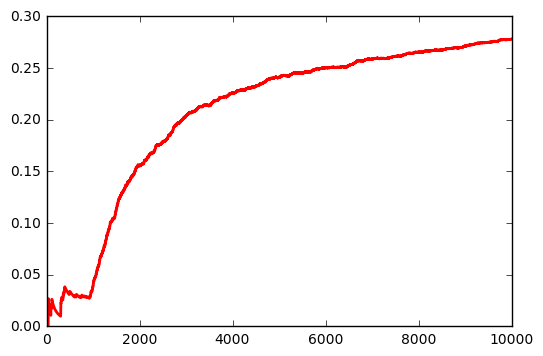

In [14]:
# plt.plot(nb_iterations, "b")
plt.plot([np.sum(np.array(nb_iterations)[:i] != 15)/i for i in range(len(nb_iterations))], "r", linewidth = 2)
plt.show()

In [152]:
N = None
Q_learned = None

for n_moves in range(10):
    
    print("\n===============================================\nBeginning with",n_moves,"moves\n\n")
    N,Q_learned,list_cumulated_reward,list_rewards,nb_iterations = Q_learning(c_init=Cube(3),Tmax=100,nb_episodes=100,n_moves = n_moves,Q_t = Q_learned,N = N)
    


Beginning with 0 moves


Finished Cube  0  (n_moves =  0 ) in  3  iterations! nan
Finished Cube  1  (n_moves =  0 ) in  1  iterations! 1.0
Finished Cube  2  (n_moves =  0 ) in  1  iterations! 1.0
Finished Cube  3  (n_moves =  0 ) in  1  iterations! 1.0
Finished Cube  5  (n_moves =  0 ) in  1  iterations! 0.8
Finished Cube  6  (n_moves =  0 ) in  1  iterations! 0.83


/home/marc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in long_scalars


Finished Cube  8  (n_moves =  0 ) in  1  iterations! 0.75
Finished Cube  9  (n_moves =  0 ) in  1  iterations! 0.78
Finished Cube  10  (n_moves =  0 ) in  1  iterations! 0.8
Finished Cube  11  (n_moves =  0 ) in  1  iterations! 0.82
Finished Cube  12  (n_moves =  0 ) in  1  iterations! 0.83
Finished Cube  13  (n_moves =  0 ) in  1  iterations! 0.85
Finished Cube  14  (n_moves =  0 ) in  1  iterations! 0.86
Finished Cube  16  (n_moves =  0 ) in  1  iterations! 0.81
Finished Cube  17  (n_moves =  0 ) in  1  iterations! 0.82
Finished Cube  18  (n_moves =  0 ) in  1  iterations! 0.83
Finished Cube  19  (n_moves =  0 ) in  1  iterations! 0.84
Finished Cube  20  (n_moves =  0 ) in  1  iterations! 0.85
Finished Cube  21  (n_moves =  0 ) in  1  iterations! 0.86
Finished Cube  23  (n_moves =  0 ) in  1  iterations! 0.83
Finished Cube  24  (n_moves =  0 ) in  3  iterations! 0.83
Finished Cube  25  (n_moves =  0 ) in  8  iterations! 0.84
Finished Cube  26  (n_moves =  0 ) in  3  iterations! 0.85
